<a href="https://colab.research.google.com/github/EagleEye1107/AI/blob/main/Efficient_Training_of_NNs_Re_materialization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torchviz

  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4131 sha256=8f98dbff9b8e0c70644508099481f8111c6ec1537c4059324c7edd0ff5e2d915
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


In [ ]:
import torch

In [ ]:
torch.__version__

'2.1.0+cu121'

##Warm up

One of the main reasons for using PyTorch in Deep Learning projects is that we can automatically get **gradients/derivatives** of functions that we define.

Given an input , we define our function by manipulating that input, usually by matrix-multiplications with weight matrices and additions with so-called bias vectors. As we manipulate our input, we are automatically creating a **computational graph**. This graph shows how to arrive at our output from our input. PyTorch is a **define-by-run** framework; this means that we can just do our manipulations, and PyTorch will keep track of that graph for us. Thus, we create a dynamic computation graph along the way.



The first thing we have to do is to specify which tensors require gradients. By default, when we create a tensor, it does not require gradients.

In [ ]:
# create a tensor [1, 1, 1] in pytorch
x =  torch.ones((3,))
print(x.requires_grad)

y = x ** 2
y.backward()

False


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

We can change this for an existing tensor using the function <font color='#ff6666'>requires_grad_()</font>



In [ ]:
x =  torch.ones((3,))
x.requires_grad_(True)

y = x ** 2

print(x.requires_grad)
print(y.requires_grad)

z = y.sum()
z.backward()
# y.backward(torch.ones(y.shape))
print(x.shape, x.grad)

True
True
torch.Size([3]) tensor([2., 2., 2.])


Alternatively, when creating a tensor, you can pass the argument requires_grad=True to most initializers we have seen above.

In [ ]:
x2 = torch.ones((3,), requires_grad=True)
print(x2.requires_grad)

True


##Computation graph : how PyTorch’s autograd does it

Conceptually, autograd keeps a record of data (tensors) & all executed operations (along with the resulting new tensors) in a directed acyclic graph (DAG) consisting of [Function](https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function) objects. In this DAG, leaves are the input tensors, roots are the output tensors. By tracing this graph from roots to leaves, you can automatically compute the gradients using the chain rule.

In a forward pass, autograd does two things simultaneously:


*       run the requested operation to compute a resulting tensor, and
*   maintain the operation's gradient function in the DAG.

The backward pass kicks off when <font color='#ff6666'>.backward()</font> is called on the DAG root. autograd then:


*  computes the gradients from each <font color='#ff6666'>.grad_fn</font>,
*   accumulates them in the respective tensor’s <font color='#ff6666'>.grad</font> attribute, and
*    using the chain rule, propagates all the way to the leaf tensors.





    
    
   


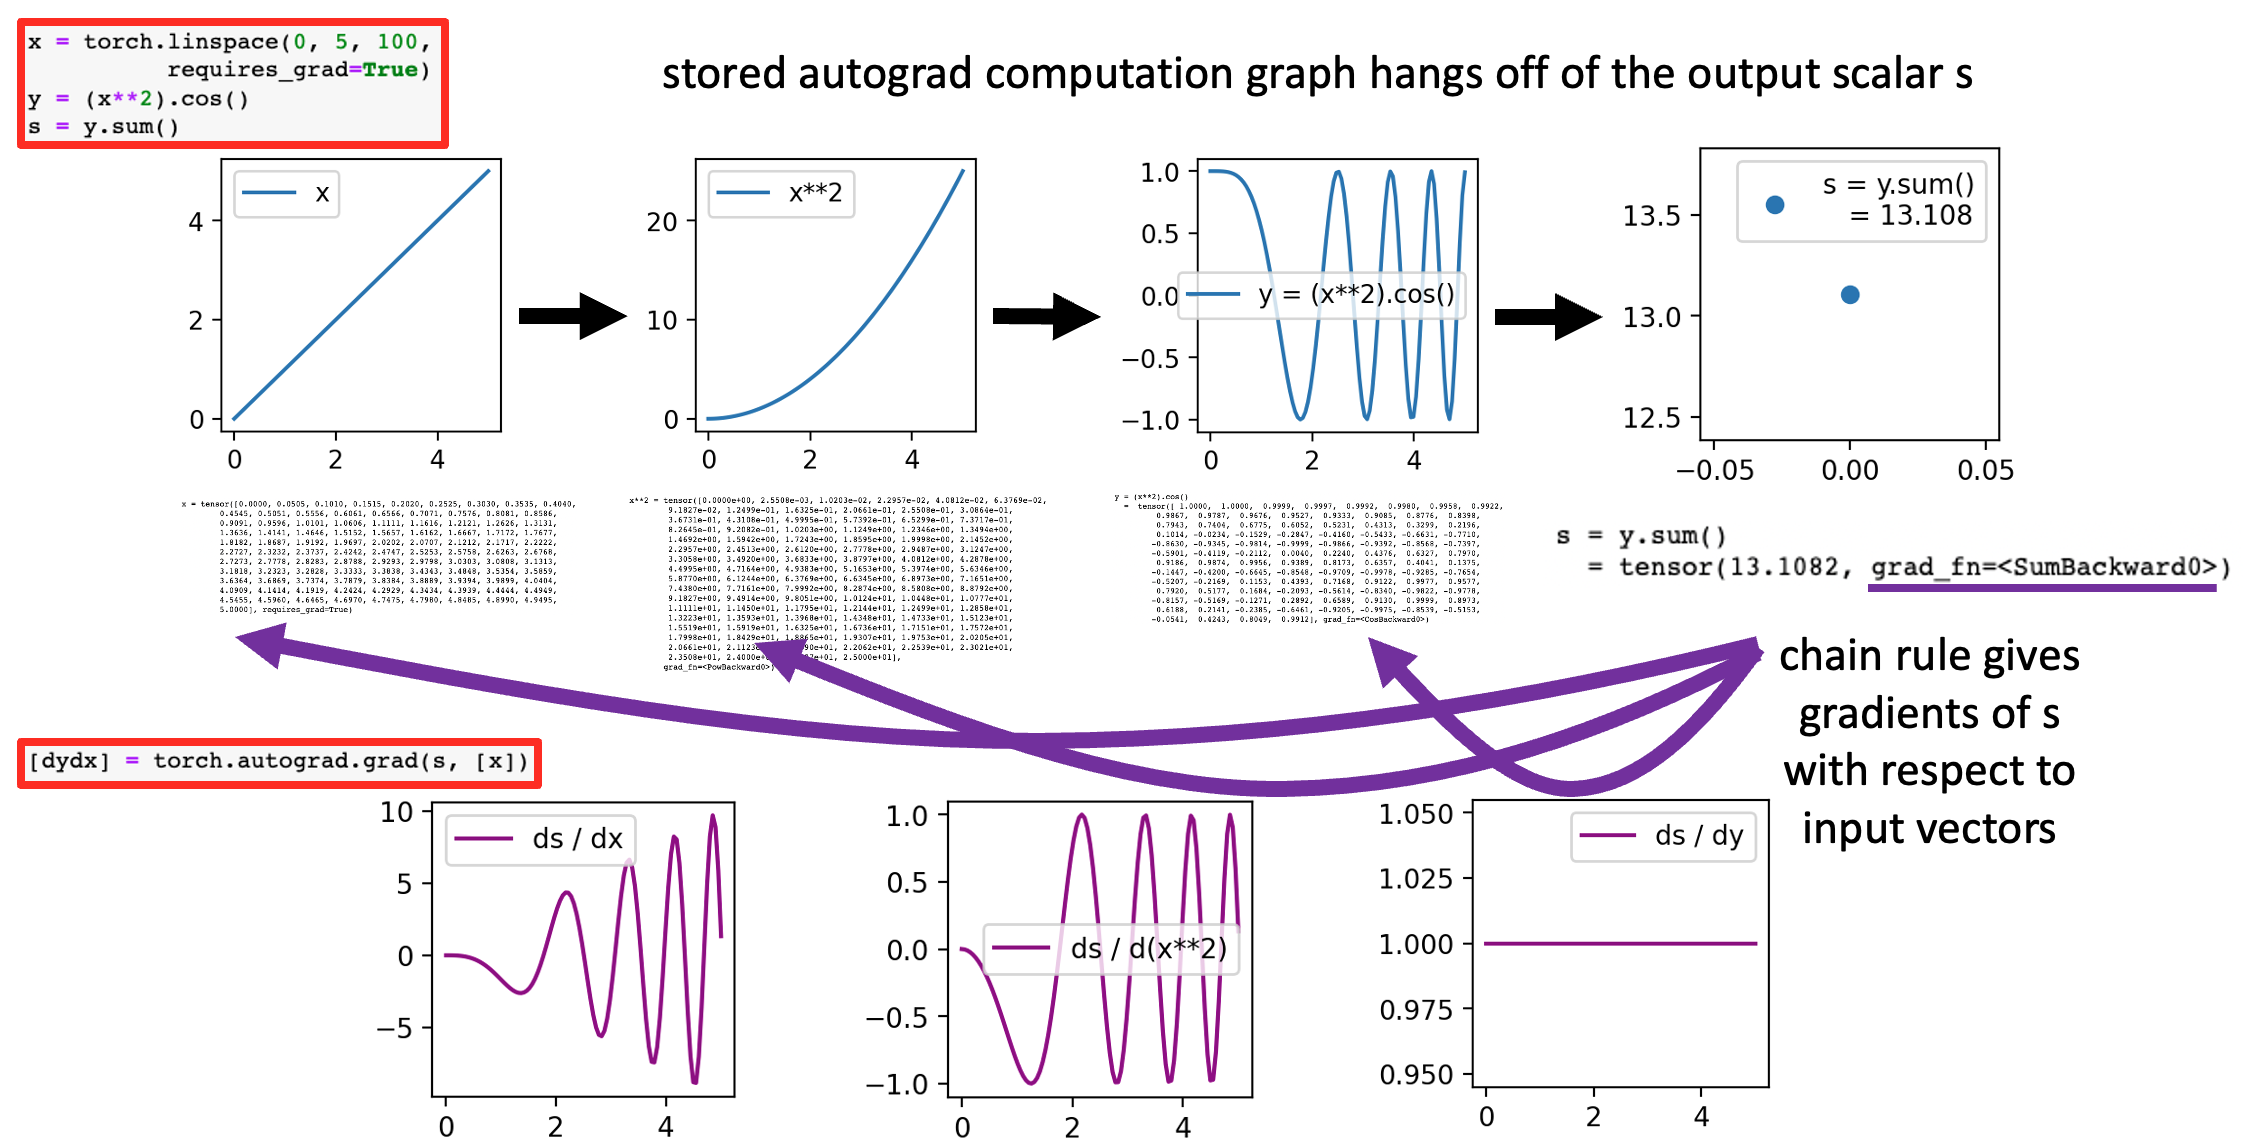

In [ ]:
import torch
x = torch.tensor([1., 2.])
true_y = torch.tensor([5., 7.])
W = torch.tensor([3.], requires_grad=True)
B = torch.tensor([5.], requires_grad=True)

# Forward
scaled = W * x
y= scaled + B
error = y - true_y
square_error =  error ** 2
loss = square_error.sum()

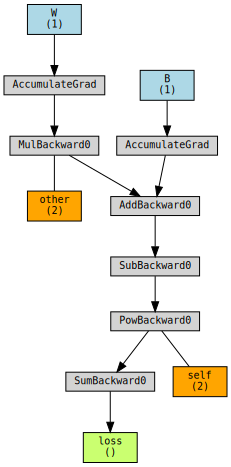

In [ ]:
import torchviz

torchviz.make_dot(loss, params={'W': W, 'B': B, 'loss':loss}, show_saved = True)

Show the saved intermediate tensor

In [ ]:
print(square_error.grad_fn._saved_self)

tensor([3., 4.], grad_fn=<SubBackward0>)


What is this AccumulateGrad Node?

Every leaf Tensor that requires gradient gets an AccumulateGrad Node associated with it. That Node is used to link back to the Tensor and know on which Tensor the gradients should be accumulated.
Note that the AccumulateGrad Nodes are the *only* Nodes that do not have parents pointing to them.

##Gradient/derivates related pytorch functions

###Torch.detach

<font color='#ff6666'>**tensor.detach()**</font> creates a tensor that shares storage with tensor that does not require grad. You should use detach() when attempting to remove a tensor from a computation graph.
In order to enable automatic differentiation, PyTorch keeps track of all operations involving tensors for which the gradient may need to be computed (i.e., require_grad is True). The operations are recorded as a directed graph. The detach() method constructs a new view on a tensor which is declared not to need gradients, i.e., it is to be excluded from further tracking of operations, and therefore the subgraph involving this view is not recorded.

In [ ]:
 #Example with detach():
x = torch.ones(10, requires_grad=True)
print(x.requires_grad)

y = x.detach()
print(y.requires_grad)

True
False


In [ ]:
#Below is a situation when we are not using detach()
x = torch.ones(10, requires_grad=True)

y = x**2
z = x**3
output = y + z

loss = output.sum()


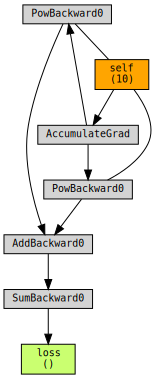

In [ ]:
import torchviz

torchviz.make_dot(loss, params={"X" : x, "loss" : loss}, show_saved = True)

In [ ]:
x.grad

In [ ]:
#TODO add some code to invoke the backward process and then print x's gradient

loss.backward()
x.grad


tensor([5., 5., 5., 5., 5., 5., 5., 5., 5., 5.])

In [ ]:
#Situation when we are using detach()
x = torch.ones(10, requires_grad=True)

y = x**2

#TODO apply detach on x before calculating ** 3
z = (x.detach())**3

output = y + z
loss = output.sum()


In [ ]:
import torchviz
#TODO get the computation graph to compare with the one in the above example and explain why
loss.backward()

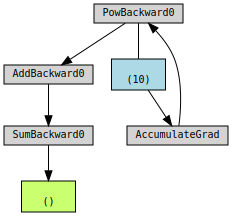

In [ ]:
#TODO add some code to invoke the backward process and then print x's gradient
torchviz.make_dot(loss, show_saved = True)



#### Question :  

**In the above example we can see that upon using detach(), the value of the gradient of the variable changes. How you can explain this ?**



####In the following scenario, it causes an error, because it detects that a has changed inplace and this will trip gradient calculation.

TODO :


*   Please run the following code and comment the line which causes the error.
*   Explain why this causes an error ?


In [ ]:
a = torch.arange(5., requires_grad=True)
b = a**2
c = a.detach()
c.zero_()
b.sum().backward()
print(a.grad)

tensor([0., 2., 4., 6., 8.])


## tensor.clone()

<font color='#ff6666'>**tensor.clone()**</font>creates a copy of tensor that imitates the original tensor's requires_grad field. We should use clone as a way to copy the tensor while still keeping the copy as a part of the computation graph it came from. Gradients propagating to the cloned tensor will propagate to the original tensor.

tensor.clone() maintains the connection with the computation graph. That means, if you use the new cloned tensor, and derive the loss from the new one, the gradients of that loss can be computed all the way back even beyond the point where the new tensor was created.

If you want to copy a tensor and detach from the computation graph you should be using

<font color='#ff6666'>**tensor.clone().detach()**</font>

In [ ]:
x=torch.ones(10, requires_grad=True)
x_clone = x.clone()

#TODO check if x_clone and x share the same storage in the memory.

y=x_clone**2
z=x_clone**3

r=(y+z).sum()
r.backward()

#TODO check the gradients of x, x_clone and explain why
#TODO print the computation graph with torchviz

## torch.no_grad()

Context-manager that disabled gradient calculation.

Disabling gradient calculation is useful for inference, when you are sure that you will not call Tensor.backward(). It will reduce memory consumption for computations that would otherwise have requires_grad=True.

In this mode, the result of every computation will have requires_grad=False, even when the inputs have requires_grad=True.

In [ ]:
#without using no_grad
x = torch.ones(3, requires_grad=True)
y = x**2
z = x**3
result = (y+z).sum()
#TODO check the attribute requires_grad of result
#TODO change the code to user torch.no_grad and then check the attribute requires_grad of result

## tensor.register_hook()

Registers a backward hook.

The hook will be called every time a gradient with respect to the Tensor is computed. The hook should have the following signature:

hook(grad) -> Tensor or None

The hook should not modify its argument, but it can optionally return a new gradient which will be used in place of grad.

This function returns a handle with a method handle.remove() that removes the hook from the module.
Use torch.Tensor.register_hook() directly on a specific input or output to get the required gradients.

In [ ]:
v = torch.tensor([0., 0., 0.], requires_grad=True)

h = v.register_hook( )  # TODO we want to double the gradient in the hook.

v.backward(torch.tensor([1., 2., 3.])) # passing a gradient to backward

#TODO check the gradient of v

tensor([2., 4., 6.])


### Implementing custom gradients

One thing you can do is define custom gradients for your own functions. There are several reasons you might want to do this, including:

1. **Speed:** You may know a faster way to compute the gradient for a specific function.
2. **Numerical Stability**
3. When your code depends on **external library calls**

In [ ]:
"""
we want to calculate the gradient for sigmoid function : y = sigmoid(x).
The gradient is calculate as grad = y(1-y)

"""

class MySigmoid(torch.autograd.Function):
    """
    We can implement our own custom autograd Functions by subclassing
    torch.autograd.Function and implementing the forward and backward passes
    which operate on Tensors.
    """

    @staticmethod
    def forward(input):
        """
        In the forward pass we receive a Tensor containing the input and return
        a Tensor containing the output.
        """

        #TODO implement the forward code for sigmoid function
        ans = ...

        return ans

    @staticmethod
    def setup_context(ctx, inputs, output):
        """
        ctx is a context object that can be used
        to stash information for backward computation. You can cache arbitrary
        objects for use in the backward pass using the ctx.save_for_backward method.
        """

        #TODO save the tensor which we will need in the backward
        ctx.save_for_backward(.........)

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor containing the gradient of the loss
        with respect to the output, and we need to compute the gradient of the loss
        with respect to the input.
        """
        #TODO Get the tensor we need from saved_tensors
        ans = ....

        #TODO give a custom method to calculate the gradient
        gradient = ......

        return gradient

In [ ]:
my_sigmoid = MySigmoid.apply

#TODO create a torch.Tensor to apply this custom function to get the gradient
x = ....
y = my_sigmoid(x)

 #TODO get gradients of x

print(x.grad)


tensor([2.], requires_grad=True)
tensor([0.8808])
tensor([2.], requires_grad=True)
tensor([0.8808], grad_fn=<MySigmoidBackward>)


0.10499362647533417

## Checkpointing

Recomputation (often called activation checkpointing) is a technique in which, instead of saving some activations for use in backwards, we recompute them during the backwards pass. Recomputing saves memory, but we incur performance overhead.

Now, lets use AOT Autograd and look at the extracted forward and backward graphs. Internally, AOT uses __torch_dispatch__ based tracing mechanism to extract forward and backward graphs, and wraps them in torch.Fx GraphModule containers.

In [ ]:
from functorch.compile import aot_function

import torch

def fn(a, b, c, d):
    x = a + b + c + d
    return x.cos().cos()

a, b, c, d = [torch.randn(2, 4, requires_grad=True) for _ in range(4)]

# The compiler_fn is called after the forward and backward graphs are extracted.
# Here, we just print the code in the compiler_fn. Return of this function is a callable.
def compiler_fn(fx_module: torch.fx.GraphModule, _):
    print(fx_module.code)
    return fx_module

# Pass on the compiler_fn to the aot_function API
aot_print_fn = aot_function(fn, fw_compiler=compiler_fn, bw_compiler=compiler_fn)
# Run the aot_print_fn once to trigger the compilation and print the graphs
cloned_inputs = [x.clone().detach().requires_grad_(True) for x in (a, b, c, d)]
cloned_a, cloned_b, cloned_c, cloned_d = cloned_inputs
res = aot_print_fn(cloned_a, cloned_b, cloned_c, cloned_d)
res.sum().backward()

The above code prints the Fx graph for the forward and backward graph. You can see that in addition to the original input of the forward pass, the forward graph outputs some additional tensors. These tensors are saved for the backward pass for gradient calculation.

If we use a partitioner fusion-aware recomputation. Please refer to this [discuss post](https://dev-discuss.pytorch.org/t/min-cut-optimal-recomputation-i-e-activation-checkpointing-with-aotautograd/467) for more details

In [ ]:
from functorch.compile import min_cut_rematerialization_partition
# Zero out the gradients so we can do a comparison later
a.grad, b.grad, c.grad, d.grad = (None,) * 4

# Lets set up the partitioner. Also set the fwd and bwd compilers to the printer function that we used earlier.
# This will show us how the recomputation has modified the graph.
aot_fn = aot_function(fn, fw_compiler=compiler_fn, bw_compiler=compiler_fn, partition_fn=min_cut_rematerialization_partition)
res = aot_fn(a, b, c, d).sum().backward()

We can see that compared to default partitioner, forward pass now outputs fewer tensors, and recomputes some operations in the backward pass.

###Rotor : Rematerializing Optimally with pyTORch

Purpose: This code is meant to replace torch/utils/checkpoint.py,
by providing more efficient checkpointing strategies. The algorithm is
easier to tune, as the required parameter as input is the available
memory instead of the number of segments.

For more details about the algorithm inside rotor, and for
experimental validation, see the paper at
https://hal.inria.fr/hal-02352969.


In [ ]:
! nvidia-smi

Sat Nov 25 19:39:57 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
%%capture
!pip install git+https://gitlab.inria.fr/hiepacs/rotor.git

In [ ]:
import torch
import rotor

In [ ]:
device='cuda'

model = rotor.models.resnet18()
model.to(device)

input = model.maxpool(model.bn1(model.conv1(torch.randn(1, 3, 224, 224).to(device))))
memory = 700*1024*1024

chk = rotor.Checkpointable(model.layer1, input, memory)
chk.all_values

/usr/local/lib/python3.10/dist-packages/torch/cuda/memory.py:329: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(


([0.32192920005484804, 0.36884920597076415],
 [0.8908799886703491, 0.8892800211906433],
 [802816, 3213312, 3213312],
 [802816, 802816, 802816],
 [0, 0],
 [5151744, 5151744])

# Example with full ResNet18



*   Fe_0: we save all activations for block#0 (intermediate + outputs)
*  CF_0 - we save only inputs to the block#0 but don't save intermediates and outputs
*  Fn_2 - we don't save neighter inputs to the block#2 nor outputs








In [ ]:
device='cuda'

model = rotor.models.resnet18()
model.to(device)

#TODO create a input tensor with correct shape for resnet18
input = torch.randn(10, 3, 224, 224).to(device)
#memory limit
memory = 200*1024*1024

chk = rotor.Checkpointable(model, input, memory,  verbosity=1)
chk.sequence

Min. memory usage: 158.9MiB
Max. memory usage: 265.3MiB  makespan  40.86972003591704


Name                                         Tf      Tb        xbar           x        tmpF        tmpB
ResNet/Conv2d[conv1]                       0.99    2.58      5.7MiB      5.7MiB    110.5KiB     -5.7MiB
ResNet/ReLUatEnd[bn1]                      0.74    1.32     30.6MiB     30.6MiB        0.0B     30.6MiB
ResNet/MaxPool2d[maxpool]                  0.25    1.12     30.6MiB     30.6MiB        0.0B        0.0B
ResNet/Sequential[layer1]/BasicBlock[0]    1.32    2.79     23.0MiB      7.7MiB        0.0B     43.8MiB
ResNet/Sequential[layer1]/BasicBlock[1]    1.25    2.72     30.6MiB      7.7MiB        0.0B     43.8MiB
ResNet/Sequential[layer2]/BasicBlock[0]    0.99    6.38     30.6MiB      7.7MiB     22.2MiB     29.8MiB
ResNet/Sequential[layer2]/BasicBlock[1]    1.04    1.98     19.1MiB      3.8MiB     26.0MiB     33.6MiB
ResNet/Sequential[layer3]/BasicBlock[0]    0.96    2.24     15.3MiB      3.8MiB     23.2MiB     27.3MiB
ResNet/Sequential[layer3]/BasicBlock[1]    0.94    1.99      9.6

[CF_0, Fn_1, Fn_2, Fe_3, Fe_4, Fe_5, Fe_6, Fe_7, Fe_8, Fe_9, Fe_10, Fe_11, Fe_12, Fe_13, L, B_13, B_12, B_11, B_10, B_9, B_8, B_7, B_6, B_5, B_4, B_3, Fe_0, Fe_1, Fe_2, B_2, B_1, B_0]

In [ ]:
from rotor import timing

times = []
repeat = 5

torch.cuda.reset_peak_memory_stats()
max_before = torch.cuda.max_memory_allocated()

timer = timing.make_timer(torch.device('cuda'))

for _ in range(repeat):
    timer.start()
    output = chk(input)
    loss = output.mean()
    del output
    loss.backward()
    del loss
    timer.end()
    times.append(timer.elapsed())

peak_mem = torch.cuda.max_memory_allocated() - max_before

Expected makespan: 22.176345103445335 memory: 124/500, 49.6MiB (52009320)
Expected makespan: 22.176345103445335 memory: 124/500, 49.6MiB (52009320)
Expected makespan: 22.176345103445335 memory: 124/500, 49.6MiB (52009320)
Expected makespan: 22.176345103445335 memory: 124/500, 49.6MiB (52009320)
Expected makespan: 22.176345103445335 memory: 124/500, 49.6MiB (52009320)


In [ ]:
peak_mem / 1024 ** 2

92.4072265625